In [1]:
import os


DDE_BACKEND = "tensorflow"
os.environ["DDE_BACKEND"] = DDE_BACKEND

In [2]:
import jax.numpy as jnp
import jinns
import jax.random as random
from jax import vmap
import jax

import equinox as eqx
import matplotlib.pyplot as plt

import deepxde as dde

key = random.PRNGKey(2)
key, subkey = random.split(key)

2025-07-04 10:31:42.008174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751617902.020910   14333 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751617902.024468   14333 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751617902.034546   14333 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751617902.034619   14333 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751617902.034621   14333 computation_placer.cc:177] computation placer alr

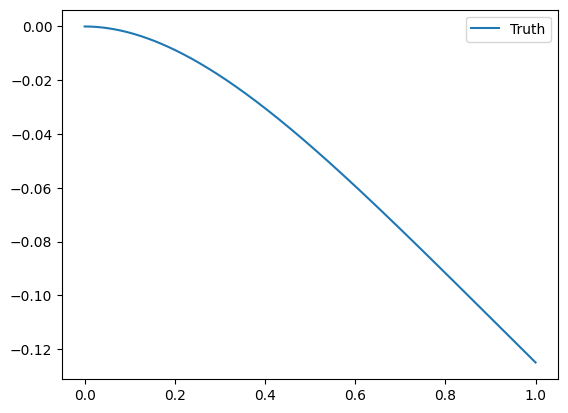

In [3]:
def u_true(x):
    return -(1 / 24) * x**4 + (1 / 6) * x**3 - (1 / 4) * x**2


v_u_true = vmap(u_true)

xs = jnp.linspace(0, 1, 1000)
plt.plot(xs, v_u_true(xs), label="Truth")
plt.legend()

## Solving Euler-Beam with Jinns

Create the neural network architecture for the PINN with `equinox`.

In [4]:
dim = 1
# same architecture as in DeepXDE example
eqx_list = (
    (eqx.nn.Linear, dim, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="statio_PDE"
)

In [5]:
n = 10
nb = 2
omega_batch_size = None  # Use full batch
omega_border_batch_size = None  # no mini-batches in dimension 1
dim = 1
min_pts = (0.0,)
max_pts = (1.0,)
method = "grid"

# -- Main difference with DeepXDE example here: we use **equidistant grid**
#  of 10 collocation points in [0,1] for training. It still works fine on this # simple example.
# Users can implement a more refined DataGenerator if they wish to use more
# complicated sampling strategy.

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_batch_size,
    dim=dim,
    min_pts=min_pts,
    max_pts=max_pts,
    method=method,
)

In [6]:
from jinns.loss import PDEStatio
from functools import partial


class EulerBeamLoss(PDEStatio):
    def equation(self, x, u, params):
        x = x[0]
        u_x = lambda x: partial(u, params=params)(x).squeeze()

        dx4 = jax.grad(jax.grad(jax.grad(jax.grad(u_x))))(x)
        return jnp.array([dx4]) + 1

In [7]:
init_params = jinns.parameters.Params(eq_params={}, nn_params=init_nn_params)

In [8]:
euler_beam_loss = EulerBeamLoss()
euler_beam_loss.equation(jnp.zeros((1,)), u, init_params)

Array([0.99908787], dtype=float32)

In [9]:
params = init_params

In [10]:
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0, boundary_loss=1.0)

In [11]:
loss = jinns.loss.LossPDEStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=euler_beam_loss,
    omega_boundary_fun=lambda _: jnp.array(
        None
    ),  # ignored for this example, hard-coded in euler-beam
    omega_boundary_condition="euler-beam",
    params=init_params,
)

In [12]:
# # Testing the loss function
# losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
# key, subkey = random.split(key)
# train_data, batch = train_data.get_batch()
# losses, grads = losses_and_grad(init_params, batch=batch)


# l_tot, dict_losses = losses
# print(f"total loss: {l_tot:.2f}")
# print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

In [13]:
train_data, batch = train_data.get_batch()
struct = jax.eval_shape(loss, init_params, batch=batch)

In [14]:
# Optimizer
import optax

# DeepXDE example uses lr=1e-3, we find it a bit too unstable for 10000 iterations
# Differences: they have a different init of NN weights and training points
tx = optax.adam(learning_rate=1e-4)
n_iter = int(10000)  # as in dde, but converges before
key, subkey = random.split(key, 2)

In [15]:
import time

t0 = time.time()
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=1000,
)
print("Elapsed time", time.time() - t0)

Initialization time: 0.6420977115631104

Compilation took
 4.885967969894409 

[train] Iteration 0: loss value = 0.9489147067070007
[train] Iteration 1000: loss value = 0.034903816878795624
[train] Iteration 2000: loss value = 0.011221230030059814
[train] Iteration 3000: loss value = 0.003691104706376791
[train] Iteration 4000: loss value = 0.0014325103256851435
[train] Iteration 5000: loss value = 0.0002766199177131057
[train] Iteration 6000: loss value = 5.4422162065748125e-05
[train] Iteration 7000: loss value = 3.0097871785983443e-05
[train] Iteration 8000: loss value = 1.480827631894499e-05
[train] Iteration 9000: loss value = 9.835326636675745e-06

Stopping main optimization loop, cause: max iteration is reached

Training took
 3.8791379928588867 


Final iteration 10000: train loss value = 7.549304882559227e-06
Elapsed time 9.554719924926758


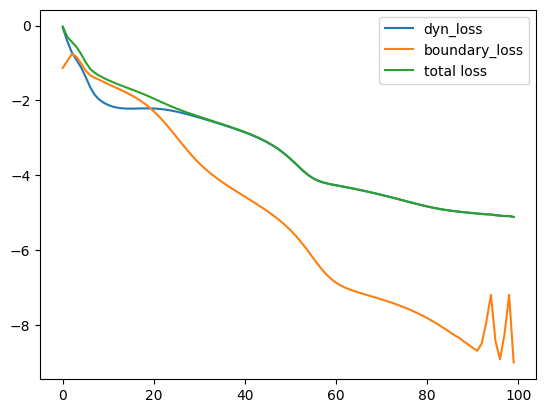

In [16]:
print_every = 100
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values)[::print_every], label=loss_name)
plt.plot(jnp.log10(total_loss_list)[::print_every], label="total loss")
plt.legend()
plt.show()

RMSE on [0,1]:  3.0635612e-05


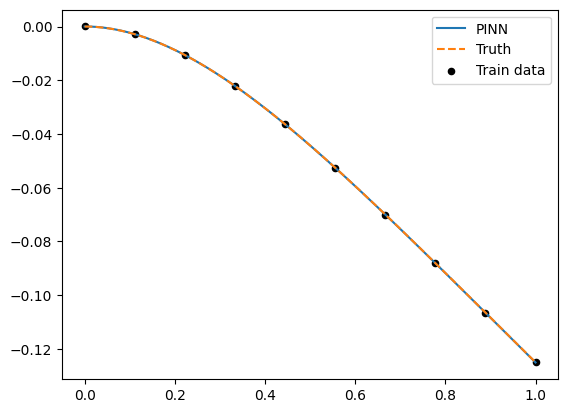

In [17]:
v_pinn_trained = vmap(lambda x: u(x, params).squeeze())

# Compute MSE on validation data
rmse = jnp.sqrt(jnp.mean((v_u_true(xs) - v_pinn_trained(xs)) ** 2))
print("RMSE on [0,1]: ", rmse)

plt.plot(xs, v_pinn_trained(xs), label="PINN")
plt.plot(xs, v_u_true(xs), "--", label="Truth")
plt.scatter(
    train_data.omega,
    v_pinn_trained(train_data.omega),
    c="black",
    s=20,
    label="Train data",
)
plt.legend()

## DeepXDE example with Tensorflow backend

You can run the cell below if you want to compare to deepXDE on your machine.

Compiling model...
'compile' took 0.040611 s

Training model...



2025-07-04 10:31:59.207096: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1751617919.207203   14333 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 661 MB memory:  -> device: 0, name: NVIDIA T1200 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


Cause: could not parse the source code of <function <lambda> at 0x7af4f014f6a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7af4f014f6a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the sourc

I0000 00:00:1751617921.554474   14333 service.cc:152] XLA service 0x52f84ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751617921.554493   14333 service.cc:160]   StreamExecutor device (0): NVIDIA T1200 Laptop GPU, Compute Capability 7.5
I0000 00:00:1751617921.644021   14333 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751617922.223695   14333 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric   
0         [3.20e-01, 0.00e+00, 1.05e+00, 2.63e-01, 2.28e-02]    [2.53e-01, 0.00e+00, 1.05e+00, 2.63e-01, 2.28e-02]    [7.46e+00]    
1000      [1.10e-03, 1.71e-08, 2.12e-05, 2.14e-04, 4.44e-05]    [6.60e-04, 1.71e-08, 2.12e-05, 2.14e-04, 4.44e-05]    [6.94e-02]    
2000      [1.79e-04, 3.14e-09, 4.94e-08, 9.80e-07, 1.00e-07]    [2.01e-04, 3.14e-09, 4.95e-08, 9.80e-07, 1.00e-07]    [9.15e-04]    
3000      [1.01e-04, 7.19e-11, 8.83e-09, 2.37e-07, 1.54e-08]    [1.18e-04, 7.19e-11, 8.77e-09, 2.36e-07, 1.54e-08]    [1.35e-03]    
4000      [6.24e-05, 3.37e-10, 3.63e-09, 1.25e-07, 4.61e-10]    [7.52e-05, 3.37e-10, 3.59e-09, 1.25e-07, 4.57e-10]    [2.69e-03]    
5000      [4.27e-05, 2.77e-08, 1.61e-07, 1.60e-07, 1.35e-07]    [5.15e-05, 2.77e-08, 1.61e-07, 1.60e-07, 1.36e-07]    [6.89e-03]    
6000      [2.65e-05, 3.02e-09, 3.69e-08, 1.30e-09, 2.30e-08]    [3.32

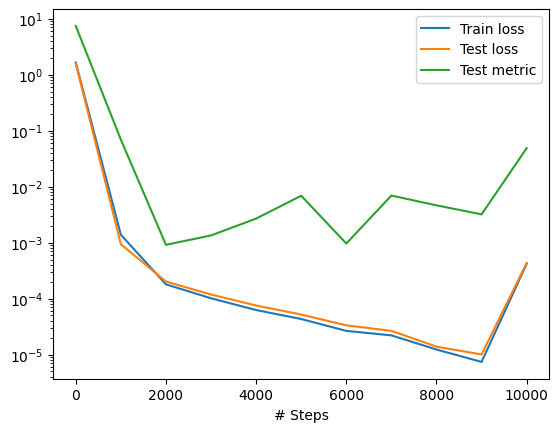

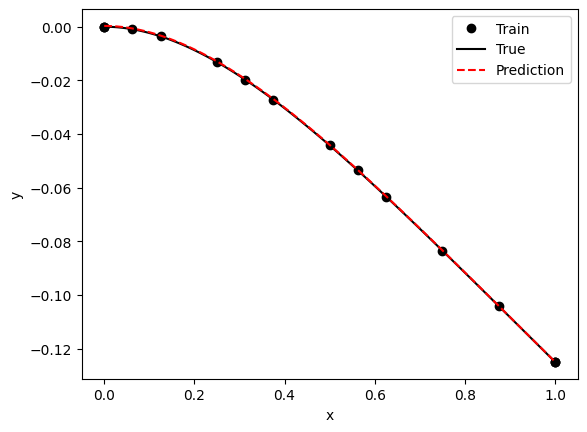

In [18]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""


def ddy(x, y):
    return dde.grad.hessian(y, x)


def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)


def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1


def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)


def func(x):
    return -(x**4) / 24 + x**3 / 6 - x**2 / 4


geom = dde.geometry.Interval(0, 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
    solution=func,
    num_test=100,
)
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)